# Imports

In [1]:
import numpy as np
import pandas as pd
import pkg_resources
import itertools
import shap
import math
import multiprocessing
from scipy.stats import norm
import matplotlib.pyplot as plt
import plotnine
from plotnine import *
plotnine.options.figure_size = (20, 10)

from xgboostlss.model import *
from xgboostlss.distributions.Gaussian_AutoGrad import Gaussian
from xgboostlss.datasets.data_loader import load_simulated_data

# Data

In [2]:
# The data is a simulated Gaussian as follows, where x is the only true feature and all others are noise variables
    # loc = 10
    # scale = 1 + 4*((0.3 < x) & (x < 0.5)) + 2*(x > 0.7)

train, test = load_simulated_data()
n_cpu = multiprocessing.cpu_count()

X_train, y_train = train.iloc[:,1:],train.iloc[:,0]
X_test, y_test = test.iloc[:,1:],test.iloc[:,0]

dtrain = xgb.DMatrix(X_train, label=y_train, nthread=n_cpu)
dtest = xgb.DMatrix(X_test, nthread=n_cpu)

# Distribution and Quantile Selection

In [3]:
distribution = Gaussian                   # Estimates both location and scale parameters of the Gaussian simultaneously.
distribution.stabilize = "None"           # Option to stabilize Gradient/Hessian. Options are "None", "MAD", "L2"
quant_sel = [0.05, 0.95]

# Hyper-Parameter Optimization

In [4]:
np.random.seed(123)

# Specifies the parameters and their value range. The structure is as follows: "hyper-parameter": [lower_bound, upper_bound]. Currently, only the following hyper-parameters can be optimized:
params = {"eta": [1e-5, 1],                   
          "max_depth": [1, 10],
          "gamma": [1e-8, 40],
          "subsample": [0.2, 1.0],
          "colsample_bytree": [0.2, 1.0],
          "min_child_weight": [0, 500]
         }

opt_params = xgboostlss.hyper_opt(params,
                                  dtrain=dtrain,
                                  dist=distribution,
                                  num_boost_round=500,       # Number of boosting iterations.
                                  max_minutes=120,           # Time budget in minutes, i.e., stop study after the given number of minutes.
                                  n_trials=None,             # The number of trials. If this argument is set to None, there is no limitation on the number of trials.
                                  silence=False)             # Controls the verbosity of the trail, i.e., user can silence the outputs of the trail.

[I 2021-12-19 14:52:23,309] A new study created in memory with name: XGBoostLSS-HyperOpt
C:\Users\Alexander\.julia\v0.6\Conda\deps\usr\envs\xgboostlss\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


0it [00:00, ?it/s]

[I 2021-12-19 14:52:34,071] Trial 0 finished with value: 1724.7831176 and parameters: {'eta': 0.030363087280807707, 'max_depth': 3, 'gamma': 1.5074442732613943e-06, 'subsample': 0.4857160809399238, 'colsample_bytree': 0.6366741608938994, 'min_child_weight': 211}. Best is trial 0 with value: 1724.7831176.
[I 2021-12-19 14:52:43,311] Trial 1 finished with value: 1742.2041137 and parameters: {'eta': 0.8013476947482925, 'max_depth': 7, 'gamma': 0.0004148938237251032, 'subsample': 0.3759312069680463, 'colsample_bytree': 0.3474570556327573, 'min_child_weight': 365}. Best is trial 0 with value: 1724.7831176.
[I 2021-12-19 14:52:59,265] Trial 2 finished with value: 1725.5295777 and parameters: {'eta': 0.0015590542353378792, 'max_depth': 1, 'gamma': 6.638115717563432e-05, 'subsample': 0.6559438243964698, 'colsample_bytree': 0.26827872970098154, 'min_child_weight': 87}. Best is trial 0 with value: 1724.7831176.
[I 2021-12-19 14:53:21,588] Trial 3 finished with value: 1724.8833496 and parameters:

# Model Training

In [5]:
np.random.seed(123)

n_rounds = opt_params["opt_rounds"]
del opt_params["opt_rounds"]

# Train Model with optimized hyper-parameters
xgboostlss_model = xgboostlss.train(opt_params,
                                    dtrain,
                                    dist=distribution,
                                    num_boost_round=n_rounds)

# Prediction

In [6]:
# Number of samples to draw from predicted distribution
n_samples=10000

# Using predicted distributional parameters, sample from distribution
pred_y = xgboostlss.predict(xgboostlss_model, 
                            dtest, 
                            dist=distribution,
                            pred_type="response",
                            n_samples=n_samples, 
                            seed=123)

# Using predicted distributional parameters, calculate quantiles
pred_quantiles = xgboostlss.predict(xgboostlss_model, 
                                    dtest, 
                                    dist=distribution,
                                    pred_type="quantiles", 
                                    quantiles=quant_sel, 
                                    seed=123)


# Returns predicted distributional parameters
pred_params = xgboostlss.predict(xgboostlss_model, 
                                 dtest, 
                                 dist=distribution,
                                 pred_type="parameters")

In [7]:
pred_y.head()

,y_pred_sample_0,y_pred_sample_1,y_pred_sample_2,y_pred_sample_3,y_pred_sample_4,y_pred_sample_5,y_pred_sample_6,y_pred_sample_7,y_pred_sample_8,y_pred_sample_9,...,y_pred_sample_9990,y_pred_sample_9991,y_pred_sample_9992,y_pred_sample_9993,y_pred_sample_9994,y_pred_sample_9995,y_pred_sample_9996,y_pred_sample_9997,y_pred_sample_9998,y_pred_sample_9999
0,8.393517,9.719960,12.389366,10.246340,8.313634,8.605790,12.417549,11.518997,4.817986,4.345027,...,9.595676,11.724306,8.696751,14.341394,16.732491,14.632256,13.891586,6.522145,5.580202,11.853166
1,8.205713,11.412811,10.064346,10.116783,12.387051,14.478045,15.082191,7.643960,5.157917,7.181320,...,10.307534,7.345740,11.866597,9.968507,12.222306,10.341982,13.040275,11.569391,5.452160,10.349101
2,11.809381,9.577482,11.170782,9.765377,10.657075,9.046274,11.795145,9.857722,9.945431,7.036578,...,8.448263,10.393054,12.373162,10.663087,7.798280,10.578048,10.536902,11.516692,8.927985,11.889153
3,12.484565,17.855137,5.729648,13.530909,9.660552,1.821424,17.836773,19.823469,14.717037,3.468232,...,13.270767,20.973759,2.484291,16.541626,0.560205,3.534415,10.423380,7.969657,18.777840,13.992102
4,8.166951,7.247478,7.931489,13.616274,8.513195,3.828480,9.672165,5.239453,10.819054,15.666119,...,5.087842,9.763971,5.755453,14.065692,14.796177,5.202057,10.283340,12.328952,6.832352,4.988074


In [8]:
pred_quantiles.head()

,y_quant_0.05,y_quant_0.95
0,5.467800,14.920080
1,5.984976,14.353956
2,7.740974,12.765633
3,0.293314,19.364445
4,2.938233,16.702328


In [9]:
pred_params.head()

,location,scale
0,10.193940,2.873290
1,10.169466,2.543989
2,10.253304,1.527388
3,9.828879,5.797212
4,9.820281,4.183988


# SHAP Interpretability

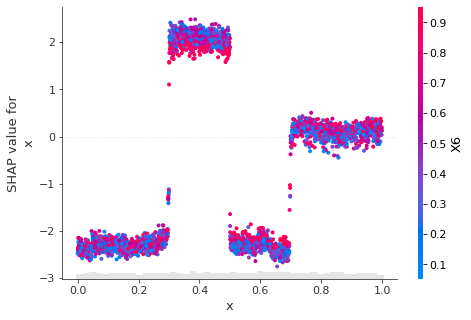

In [10]:
# Partial Dependence Plot of how x acts on variance 
xgboostlss.plot(xgboostlss_model, 
                X_test, 
                parameter="scale",
                feature="x", 
                plot_type="Partial_Dependence")

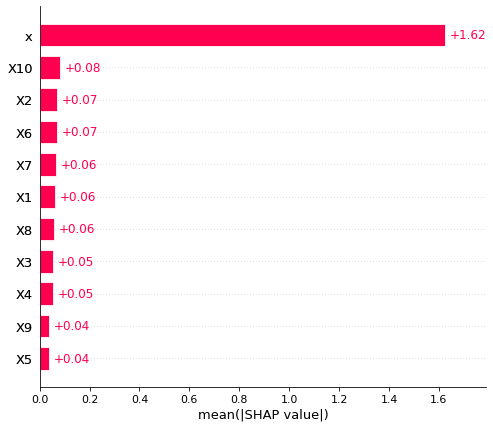

In [11]:
# Feature Importance of features on scale parameter
xgboostlss.plot(xgboostlss_model, 
                X_test, 
                parameter="scale", 
                plot_type="Feature_Importance")

# Plot of Actual vs. Predicted Quantiles

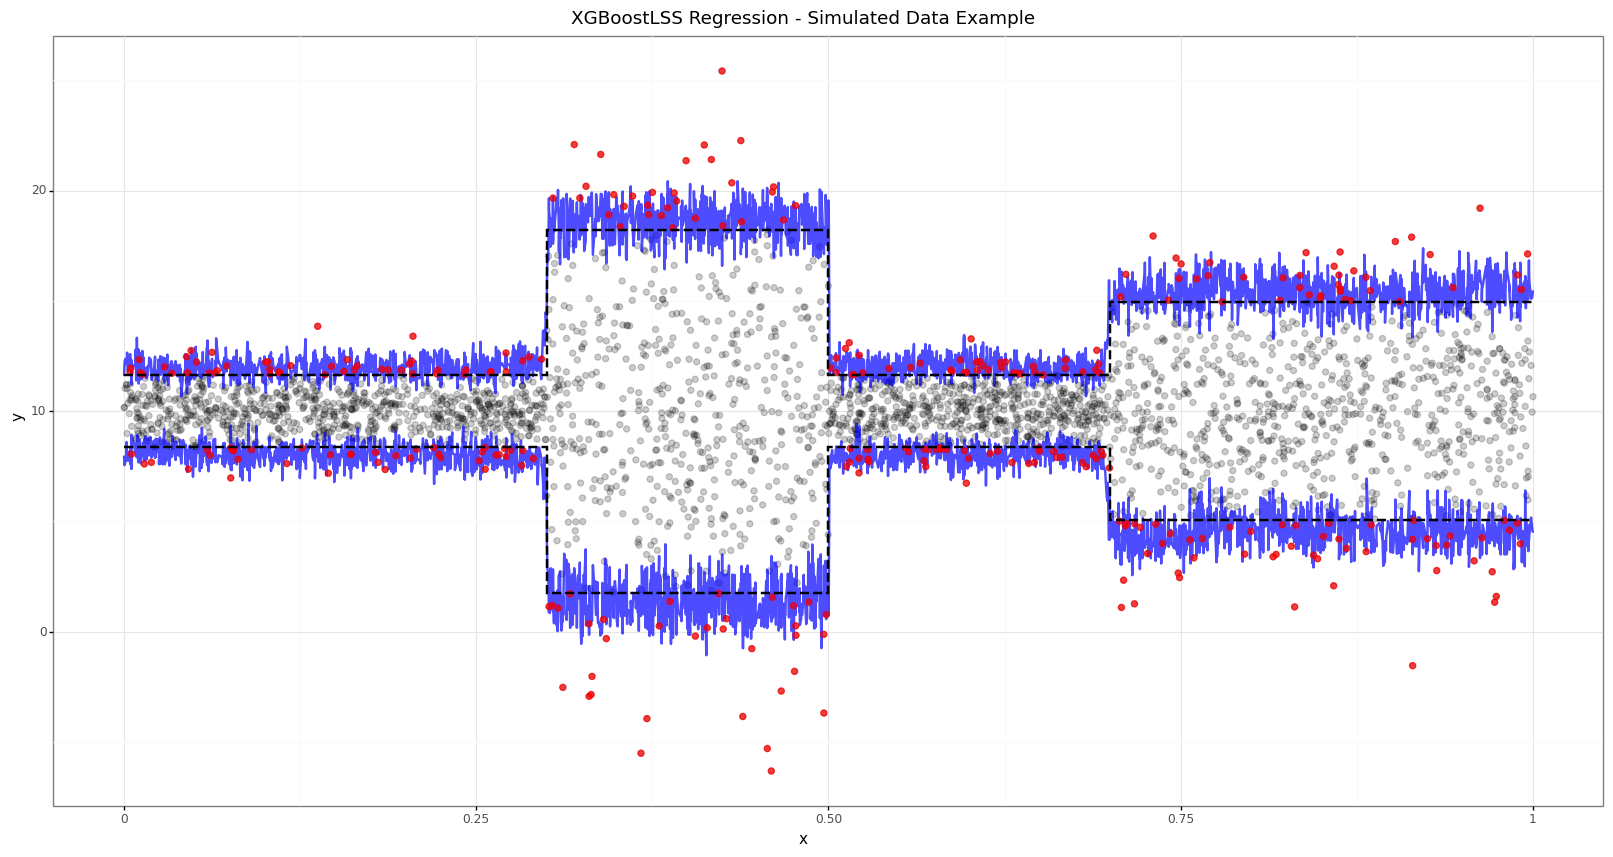

<ggplot: (-9223371925145223932)>

In [13]:
np.random.seed(123)

###
# Actual Quantiles
###
q1 = norm.ppf(quant_sel[0], loc = 10, scale = 1 + 4*((0.3 < test["x"].values) & (test["x"].values < 0.5)) + 2*(test["x"].values > 0.7))
q2 = norm.ppf(quant_sel[1], loc = 10, scale = 1 + 4*((0.3 < test["x"].values) & (test["x"].values < 0.5)) + 2*(test["x"].values > 0.7))
test["quant"] = np.where(test["y"].values < q1, 0, np.where(test["y"].values < q2, 1, 2))
test["alpha"] = np.where(test["y"].values <= q1, 1, np.where(test["y"].values >= q2, 1, 0))
df_quantiles = test[test["alpha"] == 1]

# Lower Bound
yl = list(set(q1))
yl.sort()
yl = [yl[2],yl[0],yl[2],yl[1],yl[1]]
sfunl = pd.DataFrame({"x":[0, 0.3, 0.5, 0.7, 1],
                      "y":yl})

# Upper Bound
yu = list(set(q2))
yu.sort()
yu = [yu[0],yu[2],yu[0],yu[1],yu[1]]
sfunu = pd.DataFrame({"x":[0, 0.3, 0.5, 0.7, 1],
                      "y":yu})



###
# Forecasted Quantiles
###
test["lb"] = pred_quantiles.iloc[:,0]
test["ub"] = pred_quantiles.iloc[:,1]



###
# Plot
###
(ggplot(test,
        aes("x",
            "y")) + 
 geom_point(alpha = 0.2, color = "black", size = 2) + 
 theme_bw() + 
 theme(legend_position="none",
       plot_title = element_text(hjust = 0.5)) +
 labs(title = "XGBoostLSS Regression - Simulated Data Example")  + 
 geom_line(aes("x",
               "ub"),
           size = 1,
           color = "blue", 
           alpha = 0.7) + 
 geom_line(aes("x",
               "lb"),
           size = 1,
           color = "blue", 
           alpha = 0.7) + 
 geom_point(df_quantiles,
            aes("x",
                "y"), 
            color = "red", 
            alpha = 0.7,
            size = 2) + 
 geom_step(sfunl,
           aes("x",
               "y"), 
           size = 1, 
           linetype = "dashed")  + 
 geom_step(sfunu,
           aes("x",
               "y"), 
           size = 1, 
           linetype = "dashed") 
)